# EDA and kW Prediction model for EV Charging Stations Behavior, Data from Georgia Tech campus

In [1074]:
import numpy as np
import pandas as pd
import math
import random
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
import scipy as sp
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import average_precision_score, roc_auc_score, f1_score, precision_score, \
recall_score, cohen_kappa_score, classification_report,confusion_matrix
from sklearn.model_selection import train_test_split
from datetime import datetime
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
pd.options.mode.chained_assignment = None
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width',None)

In [777]:
dataEC = pd.read_csv("EV-Charging-Raw-Data.csv")
# print(data0.columns.tolist())
# data0[0:3].T

In [778]:
dataEC.head(10)

,Label 01,Lable 02,Org Name,Start Date,Start Time Zone,End Date,End Time Zone,Transaction Date (Pacific Time),Total Duration (hh:mm:ss),Charging Time (hh:mm:ss),Energy (kWh),GHG Savings (kg),Gasoline Savings (gallons),Port Type,Port Number,Plug Type,Label 03,Label 04,Label 05,Label 06,Postal Code,Country,Label 07,Label 08,Currency,Fee,Ended By,Plug In Event Id,Driver Postal Code,User ID
0,A,A,Georgia Tech,2/13/2015 13:30,EST,2/13/2015 14:42,EST,2/13/2015 11:46,1:12:10,1:11:50,6.249,2.625,0.784,Level 2,1,J1772,A,A,A,A,30308,United States,A,A,USD,1.02,Plug Out at Vehicle,540,30102,254811.0
1,A,A,Georgia Tech,2/13/2015 12:47,EST,2/13/2015 13:45,EST,2/13/2015 10:46,0:58:39,0:58:15,4.352,1.828,0.546,Level 2,2,J1772,A,A,A,A,30308,United States,A,A,USD,0.83,Customer,539,30269,323807.0
2,A,A,Georgia Tech,2/13/2015 11:50,EST,2/13/2015 13:02,EST,2/13/2015 10:04,1:11:40,1:11:24,4.341,1.823,0.545,Level 2,1,J1772,A,A,A,A,30308,United States,A,A,USD,1.02,Plug Out at Vehicle,538,30253,345151.0
3,A,A,Georgia Tech,2/13/2015 7:43,EST,2/13/2015 12:34,EST,2/13/2015 9:36,4:50:48,3:19:30,7.857,3.300,0.986,Level 2,2,J1772,A,A,A,A,30308,United States,A,A,USD,4.12,Plug Out at Vehicle,536,30062,261355.0
4,A,A,Georgia Tech,2/13/2015 9:33,EST,2/13/2015 11:32,EST,2/13/2015 8:32,1:58:46,1:58:14,6.075,2.551,0.762,Level 2,1,J1772,A,A,A,A,30308,United States,A,A,USD,1.68,Plug Out at Vehicle,537,NaN,NaN
5,A,A,Georgia Tech,2/13/2015 7:00,EST,2/13/2015 9:24,EST,2/13/2015 6:26,2:24:09,2:23:58,7.758,3.258,0.974,Level 2,1,J1772,A,A,A,A,30308,United States,A,A,USD,2.04,Plug Out at Vehicle,535,30043,320245.0
6,A,A,Georgia Tech,2/12/2015 17:30,EST,2/12/2015 19:08,EST,2/12/2015 16:11,1:37:47,1:37:25,9.550,4.011,1.199,Level 2,2,J1772,A,A,A,A,30308,United States,A,A,USD,1.39,Plug Out at Vehicle,790,NaN,NaN
7,A,A,Georgia Tech,2/12/2015 7:09,EST,2/12/2015 10:33,EST,2/12/2015 14:48,3:24:31,3:24:24,11.275,4.735,1.415,Level 2,1,J1772,A,A,A,A,30308,United States,A,A,USD,2.90,CPS Server,531,30346,300523.0
8,A,A,Georgia Tech,2/12/2015 15:23,EST,2/12/2015 16:25,EST,2/12/2015 13:27,1:02:10,1:01:50,6.061,2.546,0.761,Level 2,2,J1772,A,A,A,A,30308,United States,A,A,USD,0.88,Customer,534,30350,335135.0
9,A,A,Georgia Tech,2/12/2015 14:55,EST,2/12/2015 16:19,EST,2/12/2015 13:21,1:24:00,1:23:29,4.019,1.688,0.504,Level 2,2,J1772,A,A,A,A,30308,United States,A,A,USD,1.19,Customer,789,30308,209813.0


In [779]:
dataEC.loc[:, 'User ID'] = 254811.0

In [780]:
# dataEC.head()

Lets check what are the numbers of unique values in the dataset to get a bit more insight.

In [781]:
# dataEC.date.value_counts()
print(dataEC.nunique())

Label 01                              1
Lable 02                              1
Org Name                              1
Start Date                         1508
Start Time Zone                       2
End Date                           1501
End Time Zone                         2
Transaction Date (Pacific Time)    1498
Total Duration (hh:mm:ss)          1413
Charging Time (hh:mm:ss)           1318
Energy (kWh)                       1378
GHG Savings (kg)                   1299
Gasoline Savings (gallons)         1058
Port Type                             1
Port Number                           2
Plug Type                             1
Label 03                              1
Label 04                              1
Label 05                              1
Label 06                              1
Postal Code                           1
Country                               1
Label 07                              1
Label 08                              1
Currency                              1


This shows some of the coulumns are only there for information, and never changes with users. For example the plug type, or postal code, currency etc. So that we can eliminate them to make the picture look a bit sharper.

In [782]:
dataEC['Start Time Zone'].value_counts()

EDT    786
EST    744
Name: Start Time Zone, dtype: int64

In [783]:
print(dataEC.columns.tolist())

['Label 01', 'Lable 02', 'Org Name', 'Start Date', 'Start Time Zone', 'End Date', 'End Time Zone', 'Transaction Date (Pacific Time)', 'Total Duration (hh:mm:ss)', 'Charging Time (hh:mm:ss)', 'Energy (kWh)', 'GHG Savings (kg)', 'Gasoline Savings (gallons)', 'Port Type', 'Port Number', 'Plug Type', 'Label 03', 'Label 04', 'Label 05', 'Label 06', 'Postal Code', 'Country', 'Label 07', 'Label 08', 'Currency', 'Fee', 'Ended By', 'Plug In Event Id', 'Driver Postal Code', 'User ID']


In [784]:
dataEC= dataEC.drop(columns=['Label 01','Driver Postal Code', 'Lable 02', 'Org Name','Start Date', 'Start Time Zone', 'End Date', 'End Time Zone', 'Port Type', 'Plug Type', 'Label 03', 'Label 04', 'Label 05', 'Label 06', 'Postal Code', 'Country', 'Label 07', 'Label 08', 'Currency', 'User ID'])

In [785]:
# dataEC.head(10000)

Which Port is more used?

In [786]:
dataEC['Port Number'].value_counts()

1    984
2    546
Name: Port Number, dtype: int64

In [787]:
dataEC.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1530 entries, 0 to 1529
Data columns (total 10 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Transaction Date (Pacific Time)  1525 non-null   object 
 1   Total Duration (hh:mm:ss)        1530 non-null   object 
 2   Charging Time (hh:mm:ss)         1530 non-null   object 
 3   Energy (kWh)                     1530 non-null   float64
 4   GHG Savings (kg)                 1530 non-null   float64
 5   Gasoline Savings (gallons)       1530 non-null   float64
 6   Port Number                      1530 non-null   int64  
 7   Fee                              1530 non-null   float64
 8   Ended By                         1523 non-null   object 
 9   Plug In Event Id                 1530 non-null   int64  
dtypes: float64(4), int64(2), object(4)
memory usage: 119.7+ KB


Lets brake down the time for months and hours. ( we could also match the day numbers with the calender from 2014-2015)  

In [789]:
dataEC['column_new'] = dataEC['Transaction Date (Pacific Time)'].str.split('/') 
# dataEC['column_new']=dataEC['column_new'].str.replace(' ', '')

In [791]:
dataEC.isna().sum()
# dataEC=dataEC.dropna()
# dataEC

Transaction Date (Pacific Time)    5
Total Duration (hh:mm:ss)          0
Charging Time (hh:mm:ss)           0
Energy (kWh)                       0
GHG Savings (kg)                   0
Gasoline Savings (gallons)         0
Port Number                        0
Fee                                0
Ended By                           7
Plug In Event Id                   0
column_new                         5
dtype: int64

In [793]:
dataEC['year']=''
for i in range(1525):
    dataEC['year'][i] = dataEC['column_new'][i][2][:4]  

In [794]:
dataEC['month']=''
for i in range(1525):
    dataEC['month'][i] = dataEC['column_new'][i][0]   
    

In [795]:
dataEC['time']=''
for i in range(1525):
    dataEC['time'][i] = dataEC['column_new'][i][2][4:]

In [796]:
dataEC['column_new'][0][2][4:]

' 11:46'

In [797]:
dataEC.head(10)

,Transaction Date (Pacific Time),Total Duration (hh:mm:ss),Charging Time (hh:mm:ss),Energy (kWh),GHG Savings (kg),Gasoline Savings (gallons),Port Number,Fee,Ended By,Plug In Event Id,column_new,year,month,time
0,2/13/2015 11:46,1:12:10,1:11:50,6.249,2.625,0.784,1,1.02,Plug Out at Vehicle,540,"[2, 13, 2015 11:46]",2015,2,11:46
1,2/13/2015 10:46,0:58:39,0:58:15,4.352,1.828,0.546,2,0.83,Customer,539,"[2, 13, 2015 10:46]",2015,2,10:46
2,2/13/2015 10:04,1:11:40,1:11:24,4.341,1.823,0.545,1,1.02,Plug Out at Vehicle,538,"[2, 13, 2015 10:04]",2015,2,10:04
3,2/13/2015 9:36,4:50:48,3:19:30,7.857,3.300,0.986,2,4.12,Plug Out at Vehicle,536,"[2, 13, 2015 9:36]",2015,2,9:36
4,2/13/2015 8:32,1:58:46,1:58:14,6.075,2.551,0.762,1,1.68,Plug Out at Vehicle,537,"[2, 13, 2015 8:32]",2015,2,8:32
5,2/13/2015 6:26,2:24:09,2:23:58,7.758,3.258,0.974,1,2.04,Plug Out at Vehicle,535,"[2, 13, 2015 6:26]",2015,2,6:26
6,2/12/2015 16:11,1:37:47,1:37:25,9.550,4.011,1.199,2,1.39,Plug Out at Vehicle,790,"[2, 12, 2015 16:11]",2015,2,16:11
7,2/12/2015 14:48,3:24:31,3:24:24,11.275,4.735,1.415,1,2.90,CPS Server,531,"[2, 12, 2015 14:48]",2015,2,14:48
8,2/12/2015 13:27,1:02:10,1:01:50,6.061,2.546,0.761,2,0.88,Customer,534,"[2, 12, 2015 13:27]",2015,2,13:27
9,2/12/2015 13:21,1:24:00,1:23:29,4.019,1.688,0.504,2,1.19,Customer,789,"[2, 12, 2015 13:21]",2015,2,13:21


In [798]:
dataEC['month'].value_counts()

1     300
10    172
9     149
11    148
12    137
2     124
8     111
4     100
3      91
5      68
7      63
6      62
        5
Name: month, dtype: int64

The reasosn 1st month is more then the rest is there are two 1st months of th eyear 2014 and 2015.

In [800]:
dataEC= dataEC.drop(columns=['Transaction Date (Pacific Time)','column_new'])

In [801]:
dataEC['column_new'] = dataEC['time'].str.split(':')

In [802]:
dataEC['min']=''
for i in range(1525):
    dataEC['min'][i] = dataEC['column_new'][i][1]

In [803]:
dataEC['hour']=''
for i in range(1525):
    dataEC['hour'][i] = dataEC['column_new'][i][0]

In [804]:
dataEC.time[0][1:3]

'11'

Btw- What is the distibution of the methods used for ending a charge?

In [806]:
dataEC['Ended By'].value_counts()

Plug Out at Vehicle             1088
Customer                         312
CPS Server                        64
Timeout                           58
Plug Removed While Rebooting       1
Name: Ended By, dtype: int64

Turns out not useful info for now. Lets keep working on time and day seperation.

In [807]:
dataEC=dataEC[:1525]

In [808]:
dataEC['min'][2][0]

'0'

In [809]:
dataEC['min-n']=''
for i in range(1525):
    if dataEC['min'][i][0]=='0'and dataEC['min'][i][1]!='0':
        dataEC['min-n'][i]=dataEC['min'][i].replace('0', '')
    elif dataEC['min'][i][0]=='0' and dataEC['min'][i][1]=='0':
            dataEC['min-n'][i]=dataEC['min'][i][0]
    else:
            dataEC['min-n'][i]=dataEC['min'][i]
      

In [810]:
dataEC= dataEC.drop(columns=['column_new'])

In [811]:
dataEC.isna().sum()

Total Duration (hh:mm:ss)     0
Charging Time (hh:mm:ss)      0
Energy (kWh)                  0
GHG Savings (kg)              0
Gasoline Savings (gallons)    0
Port Number                   0
Fee                           0
Ended By                      2
Plug In Event Id              0
year                          0
month                         0
time                          0
min                           0
hour                          0
min-n                         0
dtype: int64

In [812]:
dataEC['min-n']=dataEC['min-n'].astype(str).astype(int)

In [813]:
dataEC['hour']=dataEC['hour'].astype(str).astype(int)

lets make it like this: if the minute is bigger than 30, then increase the hour by 1, if not leave it as is. 

In [815]:
dataEC['flat hour']=''
for i in range(len(dataEC['time'])):
    if dataEC['min-n'][i]>30:
        dataEC['flat hour'][i]=dataEC['hour'][i]+1
    else: 
        dataEC['flat hour'][i]=dataEC['hour'][i]
    


Lets calculate Charging time and Charging speed.

In [817]:
dataEC= dataEC.drop(columns=['time','min','min-n','hour'])

In [818]:
data1=dataEC[['Energy (kWh)','Charging Time (hh:mm:ss)']]
data2=data1.dropna()

In [819]:
seconds=[]
for i in range(len(dataEC['Charging Time (hh:mm:ss)'])):
    time=dataEC['Charging Time (hh:mm:ss)'][i]
    time2=time.split(':')
    seconds+=[int(time2[0])*3600+int(time2[1])*60+int(time2[2])]

In [820]:
charge=[]
for i in range(len(dataEC['Charging Time (hh:mm:ss)'])):
    time=dataEC['Charging Time (hh:mm:ss)'][i]
    time2=time.split(':')
    charge+=[(int(time2[0])*3600+int(time2[1])*60+int(time2[2]))/60]

In [821]:
dataEC['seconds']=seconds

In [822]:
dataEC['Charging Time(min)']=charge

In [823]:
dataEC['Charging Speed(kWh/h)']=dataEC['Energy (kWh)']/dataEC['seconds']*3600
dataEC

,Total Duration (hh:mm:ss),Charging Time (hh:mm:ss),Energy (kWh),GHG Savings (kg),Gasoline Savings (gallons),Port Number,Fee,Ended By,Plug In Event Id,year,month,flat hour,seconds,Charging Time(min),Charging Speed(kWh/h)
0,1:12:10,1:11:50,6.249,2.625,0.784,1,1.02,Plug Out at Vehicle,540,2015,2,12,4310,71.833333,5.219582
1,0:58:39,0:58:15,4.352,1.828,0.546,2,0.83,Customer,539,2015,2,11,3495,58.250000,4.482747
2,1:11:40,1:11:24,4.341,1.823,0.545,1,1.02,Plug Out at Vehicle,538,2015,2,10,4284,71.400000,3.647899
3,4:50:48,3:19:30,7.857,3.300,0.986,2,4.12,Plug Out at Vehicle,536,2015,2,10,11970,199.500000,2.363008
4,1:58:46,1:58:14,6.075,2.551,0.762,1,1.68,Plug Out at Vehicle,537,2015,2,9,7094,118.233333,3.082887
5,2:24:09,2:23:58,7.758,3.258,0.974,1,2.04,Plug Out at Vehicle,535,2015,2,6,8638,143.966667,3.233248
6,1:37:47,1:37:25,9.550,4.011,1.199,2,1.39,Plug Out at Vehicle,790,2015,2,16,5845,97.416667,5.881950
7,3:24:31,3:24:24,11.275,4.735,1.415,1,2.90,CPS Server,531,2015,2,15,12264,204.400000,3.309687
8,1:02:10,1:01:50,6.061,2.546,0.761,2,0.88,Customer,534,2015,2,13,3710,61.833333,5.881294
9,1:24:00,1:23:29,4.019,1.688,0.504,2,1.19,Customer,789,2015,2,13,5009,83.483333,2.888481


In [824]:
duration=[]
for i in range(len(dataEC['Total Duration (hh:mm:ss)'])):
    time=dataEC['Total Duration (hh:mm:ss)'][i]
    time2=time.split(':')
    duration+=[(int(time2[0])*3600+int(time2[1])*60+int(time2[2]))/60]

In [825]:
dataEC['plug-out time(min)']=duration

In [826]:
dataEC['plug-out(min)']=dataEC['plug-out time(min)']-dataEC['Charging Time(min)']

In [827]:
dataEC1=dataEC.drop(columns=['Total Duration (hh:mm:ss)','Charging Time (hh:mm:ss)','seconds'])

In [828]:
dataEC1=dataEC1.drop(columns=['Plug In Event Id','plug-out time(min)'])

Finally we have a bit cleaner dataset:

In [829]:
dataEC1.head(100)

,Energy (kWh),GHG Savings (kg),Gasoline Savings (gallons),Port Number,Fee,Ended By,year,month,flat hour,Charging Time(min),Charging Speed(kWh/h),plug-out(min)
0,6.249,2.625,0.784,1,1.02,Plug Out at Vehicle,2015,2,12,71.833333,5.219582,0.333333
1,4.352,1.828,0.546,2,0.83,Customer,2015,2,11,58.250000,4.482747,0.400000
2,4.341,1.823,0.545,1,1.02,Plug Out at Vehicle,2015,2,10,71.400000,3.647899,0.266667
3,7.857,3.300,0.986,2,4.12,Plug Out at Vehicle,2015,2,10,199.500000,2.363008,91.300000
4,6.075,2.551,0.762,1,1.68,Plug Out at Vehicle,2015,2,9,118.233333,3.082887,0.533333
5,7.758,3.258,0.974,1,2.04,Plug Out at Vehicle,2015,2,6,143.966667,3.233248,0.183333
6,9.550,4.011,1.199,2,1.39,Plug Out at Vehicle,2015,2,16,97.416667,5.881950,0.366667
7,11.275,4.735,1.415,1,2.90,CPS Server,2015,2,15,204.400000,3.309687,0.116667
8,6.061,2.546,0.761,2,0.88,Customer,2015,2,13,61.833333,5.881294,0.333333
9,4.019,1.688,0.504,2,1.19,Customer,2015,2,13,83.483333,2.888481,0.516667


In [830]:
# from pathlib import Path  
# filepath = Path("EV Charging Processed Data")  
# filepath.parent.mkdir(parents=True, exist_ok=True)  
# dataEC1.to_csv(filepath,index=False)  

# Processed Data

In [831]:
data = pd.read_csv("EV Charging Processed Data")

In [832]:
data.head()

,Energy (kWh),GHG Savings (kg),Gasoline Savings (gallons),Port Number,Fee,Ended By,year,month,flat hour,Charging Speed(kWh/h),Charging Time(min),plug-out(min)
0,6.249,2.625,0.784,1,1.02,Plug Out at Vehicle,2015,2,12,5.219582,71.833333,0.333333
1,4.352,1.828,0.546,2,0.83,Customer,2015,2,11,4.482747,58.250000,0.400000
2,4.341,1.823,0.545,1,1.02,Plug Out at Vehicle,2015,2,10,3.647899,71.400000,0.266667
3,7.857,3.300,0.986,2,4.12,Plug Out at Vehicle,2015,2,10,2.363008,199.500000,91.300000
4,6.075,2.551,0.762,1,1.68,Plug Out at Vehicle,2015,2,9,3.082887,118.233333,0.533333


In [833]:
data.groupby(['year']).count()

,Energy (kWh),GHG Savings (kg),Gasoline Savings (gallons),Port Number,Fee,Ended By,month,flat hour,Charging Speed(kWh/h),Charging Time(min),plug-out(min)
year,,,,,,,,,,,
2014,1268,1268,1268,1268,1268,1268,1268,1268,1185,1268,1268
2015,257,257,257,257,257,257,257,257,250,257,257


In [834]:
data['Energy (kWh)'].sum()

14185.499

Display Plugged In and Out Without Charging

In [835]:
data['Charging Speed(kWh/h)'].isna().sum()

90

In [837]:
# data['year']=data['year'].astype(str).astype(int)

How many times plugged in- graph by months- we can only compare 1st month of the years 2014 and 2015.

There is more plug in activity in January 2015 that the previous year's.

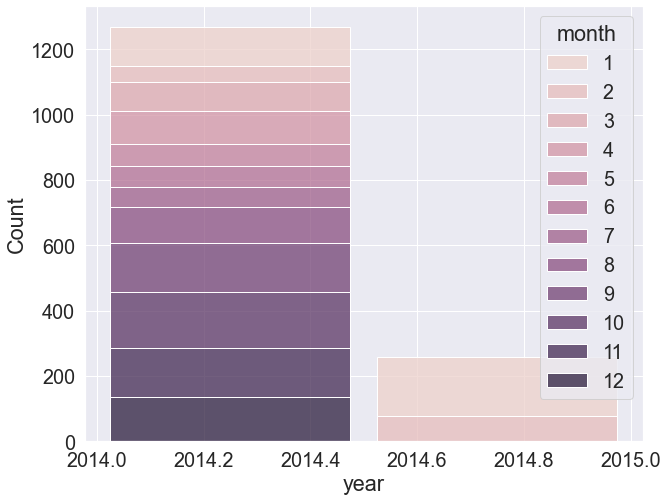

In [838]:
fig_dims = (10, 8)
fig, ax = plt.subplots(figsize=fig_dims)
sns.histplot(data=data, x="year",hue="month", multiple="stack",shrink=.9,bins=2)
#ax.set_xticks(range(1,2015))
plt.show()
# sns.histplot(data['year'], ax=ax, color='C2',bins=80)

We can see from the denser color: Fees are paind generally below 5 USD per session while charging around 6kW and 3kW per hour speed

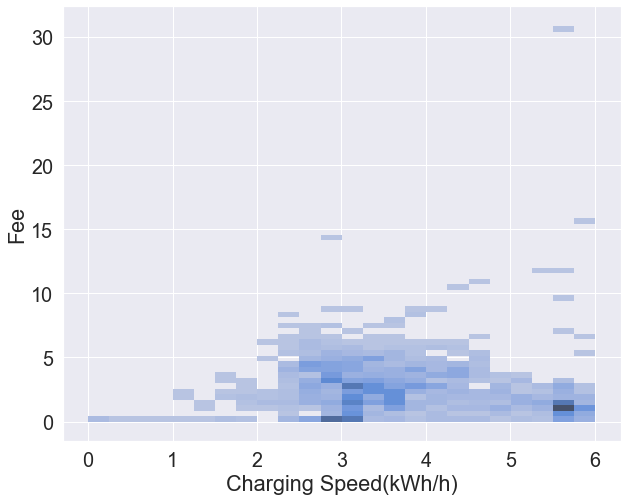

In [839]:
fig_dims = (10, 8)
fig, ax = plt.subplots(figsize=fig_dims)
sns.histplot(data=data, x='Charging Speed(kWh/h)',y='Fee')
#ax.set_xticks(range(1,2015))
plt.show()
# sns.histplot(data['year'], ax=ax, color='C2',bins=80)

Charging speed frequency in different time of the days. You can see the dark green colors around 9:00 and 18:30 with avg 3kW/h

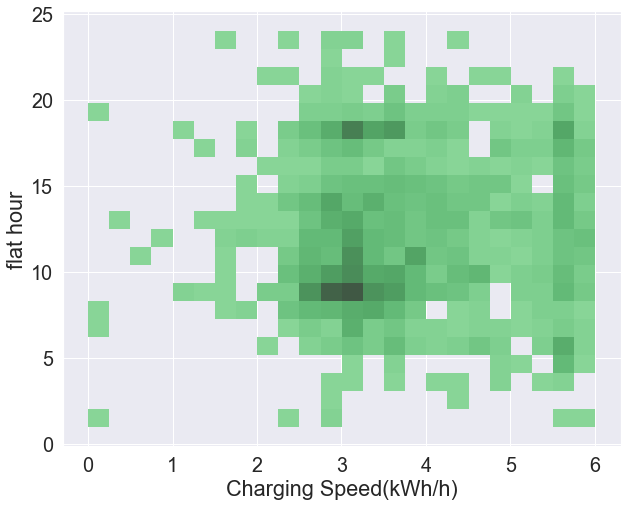

In [840]:
fig_dims = (10, 8)
fig, ax = plt.subplots(figsize=fig_dims)
sns.histplot(data=data, x='Charging Speed(kWh/h)',y='flat hour',color ='C2')
#ax.set_xticks(range(1,2015))
plt.show()
# sns.histplot(data['year'], ax=ax, color='C2',bins=80)

Energy consumtion frequency during the day

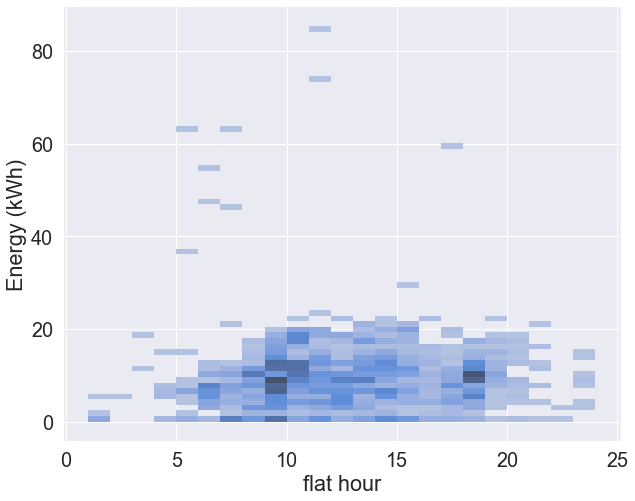

In [841]:
fig_dims = (10, 8)
fig, ax = plt.subplots(figsize=fig_dims)
sns.histplot(data=data, x='flat hour',y='Energy (kWh)')
#ax.set_xticks(range(1,2015))
plt.show()
# sns.histplot(data['year'], ax=ax, color='C2',bins=80)

Same for Fees paid 

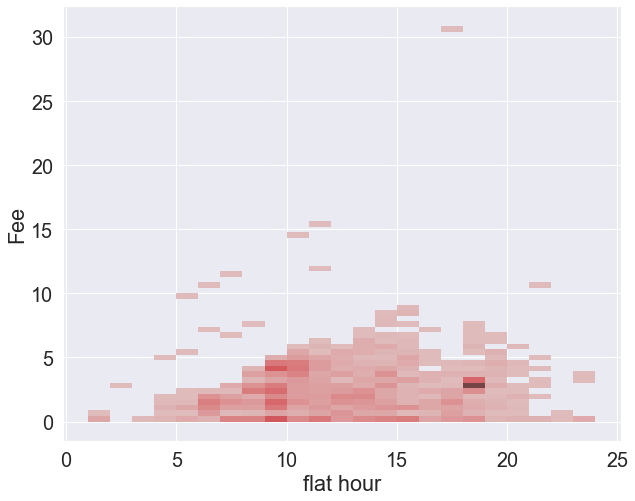

In [842]:
fig_dims = (10, 8)
fig, ax = plt.subplots(figsize=fig_dims)
sns.histplot(data=data, x='flat hour',y='Fee',color='C3')
#ax.set_xticks(range(1,2015))
plt.show()
# sns.histplot(data['year'], ax=ax, color='C2',bins=80)

In [843]:
data['kW fee']=data['Fee']/data['Energy (kWh)']

In [844]:
data.head(2000)

,Energy (kWh),GHG Savings (kg),Gasoline Savings (gallons),Port Number,Fee,Ended By,year,month,flat hour,Charging Speed(kWh/h),Charging Time(min),plug-out(min),kW fee
0,6.249,2.625,0.784,1,1.02,Plug Out at Vehicle,2015,2,12,5.219582,71.833333,0.333333,0.163226
1,4.352,1.828,0.546,2,0.83,Customer,2015,2,11,4.482747,58.250000,0.400000,0.190717
2,4.341,1.823,0.545,1,1.02,Plug Out at Vehicle,2015,2,10,3.647899,71.400000,0.266667,0.234969
3,7.857,3.300,0.986,2,4.12,Plug Out at Vehicle,2015,2,10,2.363008,199.500000,91.300000,0.524373
4,6.075,2.551,0.762,1,1.68,Plug Out at Vehicle,2015,2,9,3.082887,118.233333,0.533333,0.276543
5,7.758,3.258,0.974,1,2.04,Plug Out at Vehicle,2015,2,6,3.233248,143.966667,0.183333,0.262954
6,9.550,4.011,1.199,2,1.39,Plug Out at Vehicle,2015,2,16,5.881950,97.416667,0.366667,0.145550
7,11.275,4.735,1.415,1,2.90,CPS Server,2015,2,15,3.309687,204.400000,0.116667,0.257206
8,6.061,2.546,0.761,2,0.88,Customer,2015,2,13,5.881294,61.833333,0.333333,0.145191
9,4.019,1.688,0.504,2,1.19,Customer,2015,2,13,2.888481,83.483333,0.516667,0.296094


Thi graph is a bit controversial, since we can see that events are quite few when the kw price is increased.
However we can not know for sure whether this  means people avoided charging when kwFee was high or most of the time prices were stable and rarely increased so that is why events are just a few. We will discover that relationship later...

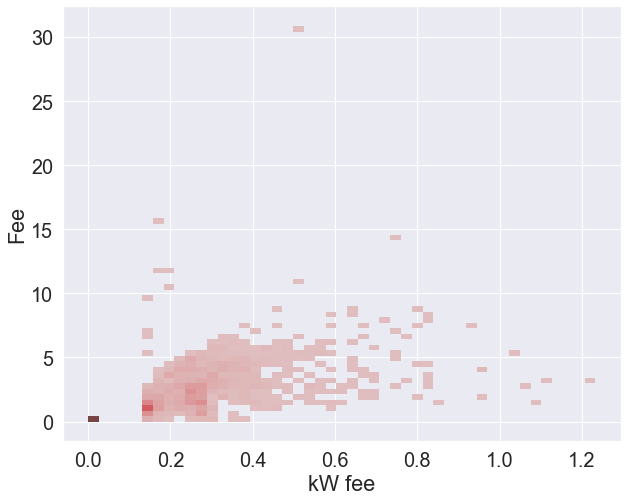

In [845]:
fig_dims = (10, 8)
fig, ax = plt.subplots(figsize=fig_dims)
sns.histplot(data=data, x='kW fee',y='Fee',color='C3')
#ax.set_xticks(range(1,2015))
plt.show()
# sns.histplot(data['year'], ax=ax, color='C2',bins=80)

kW fee price concentrating btw 0.2-0.4$ during rush hours 8:30 and 18:00, 

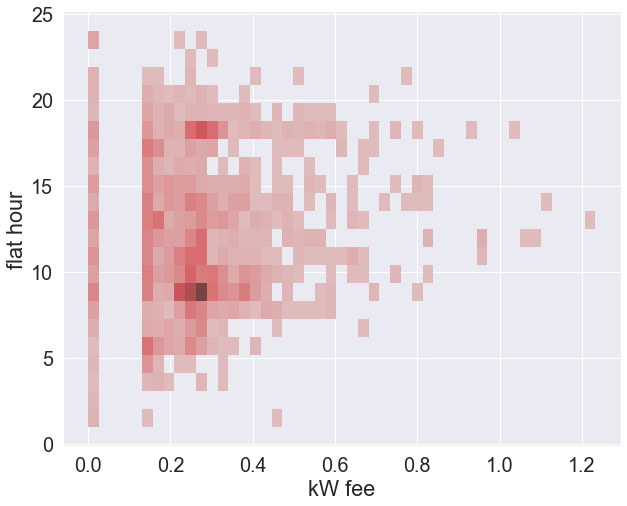

In [846]:
fig_dims = (10, 8)
fig, ax = plt.subplots(figsize=fig_dims)
sns.histplot(data=data, x='kW fee',y='flat hour',color='C3')
#ax.set_xticks(range(1,2015))
plt.show()
# sns.histplot(data['year'], ax=ax, color='C2',bins=80)

Statistical description of the dataset

In [847]:
data.describe()

,Energy (kWh),GHG Savings (kg),Gasoline Savings (gallons),Port Number,Fee,year,month,flat hour,Charging Speed(kWh/h),Charging Time(min),plug-out(min),kW fee
count,1525.000000,1525.000000,1525.000000,1525.000000,1525.000000,1525.000000,1525.000000,1525.000000,1435.000000,1525.000000,1525.000000,1440.000000
mean,9.301967,3.906818,1.167391,1.356066,2.433436,2014.168525,6.291803,12.070820,3.756904,153.778940,35.687388,inf
std,6.559982,2.755203,0.823287,0.478992,1.992246,0.374454,3.957878,4.044564,1.085306,97.921175,78.721418,NaN
min,0.000000,0.000000,0.000000,1.000000,0.000000,2014.000000,1.000000,1.000000,0.000000,0.000000,-0.250000,0.000000
25%,5.397000,2.267000,0.677000,1.000000,1.060000,2014.000000,2.000000,9.000000,2.995766,84.333333,0.433333,0.175431
50%,8.932000,3.751000,1.121000,1.000000,2.190000,2014.000000,7.000000,12.000000,3.498310,146.150000,1.333333,0.255824
75%,12.376000,5.198000,1.553000,2.000000,3.590000,2014.000000,10.000000,15.000000,4.452119,213.433333,37.833333,0.327245
max,85.385000,35.862000,10.716000,2.000000,30.860000,2015.000000,12.000000,24.000000,6.005581,865.550000,1542.850000,inf


In [848]:
data['kW fee'] = data['kW fee'].replace(np.inf, np.nan)

In [849]:
data['kW fee'].mean(skipna=True)

0.2706540193173848

In [851]:
data['plug-out(min)']=data['plug-out(min)'].abs()

Correlation matrix. Most of the correlations are expected or relative. One interesting exception is the negative corr. btw kW/fee and charging speed. Simultaniously, charging speed being low and kW/fee being high might indicate a general energy shortage during that particular events. 

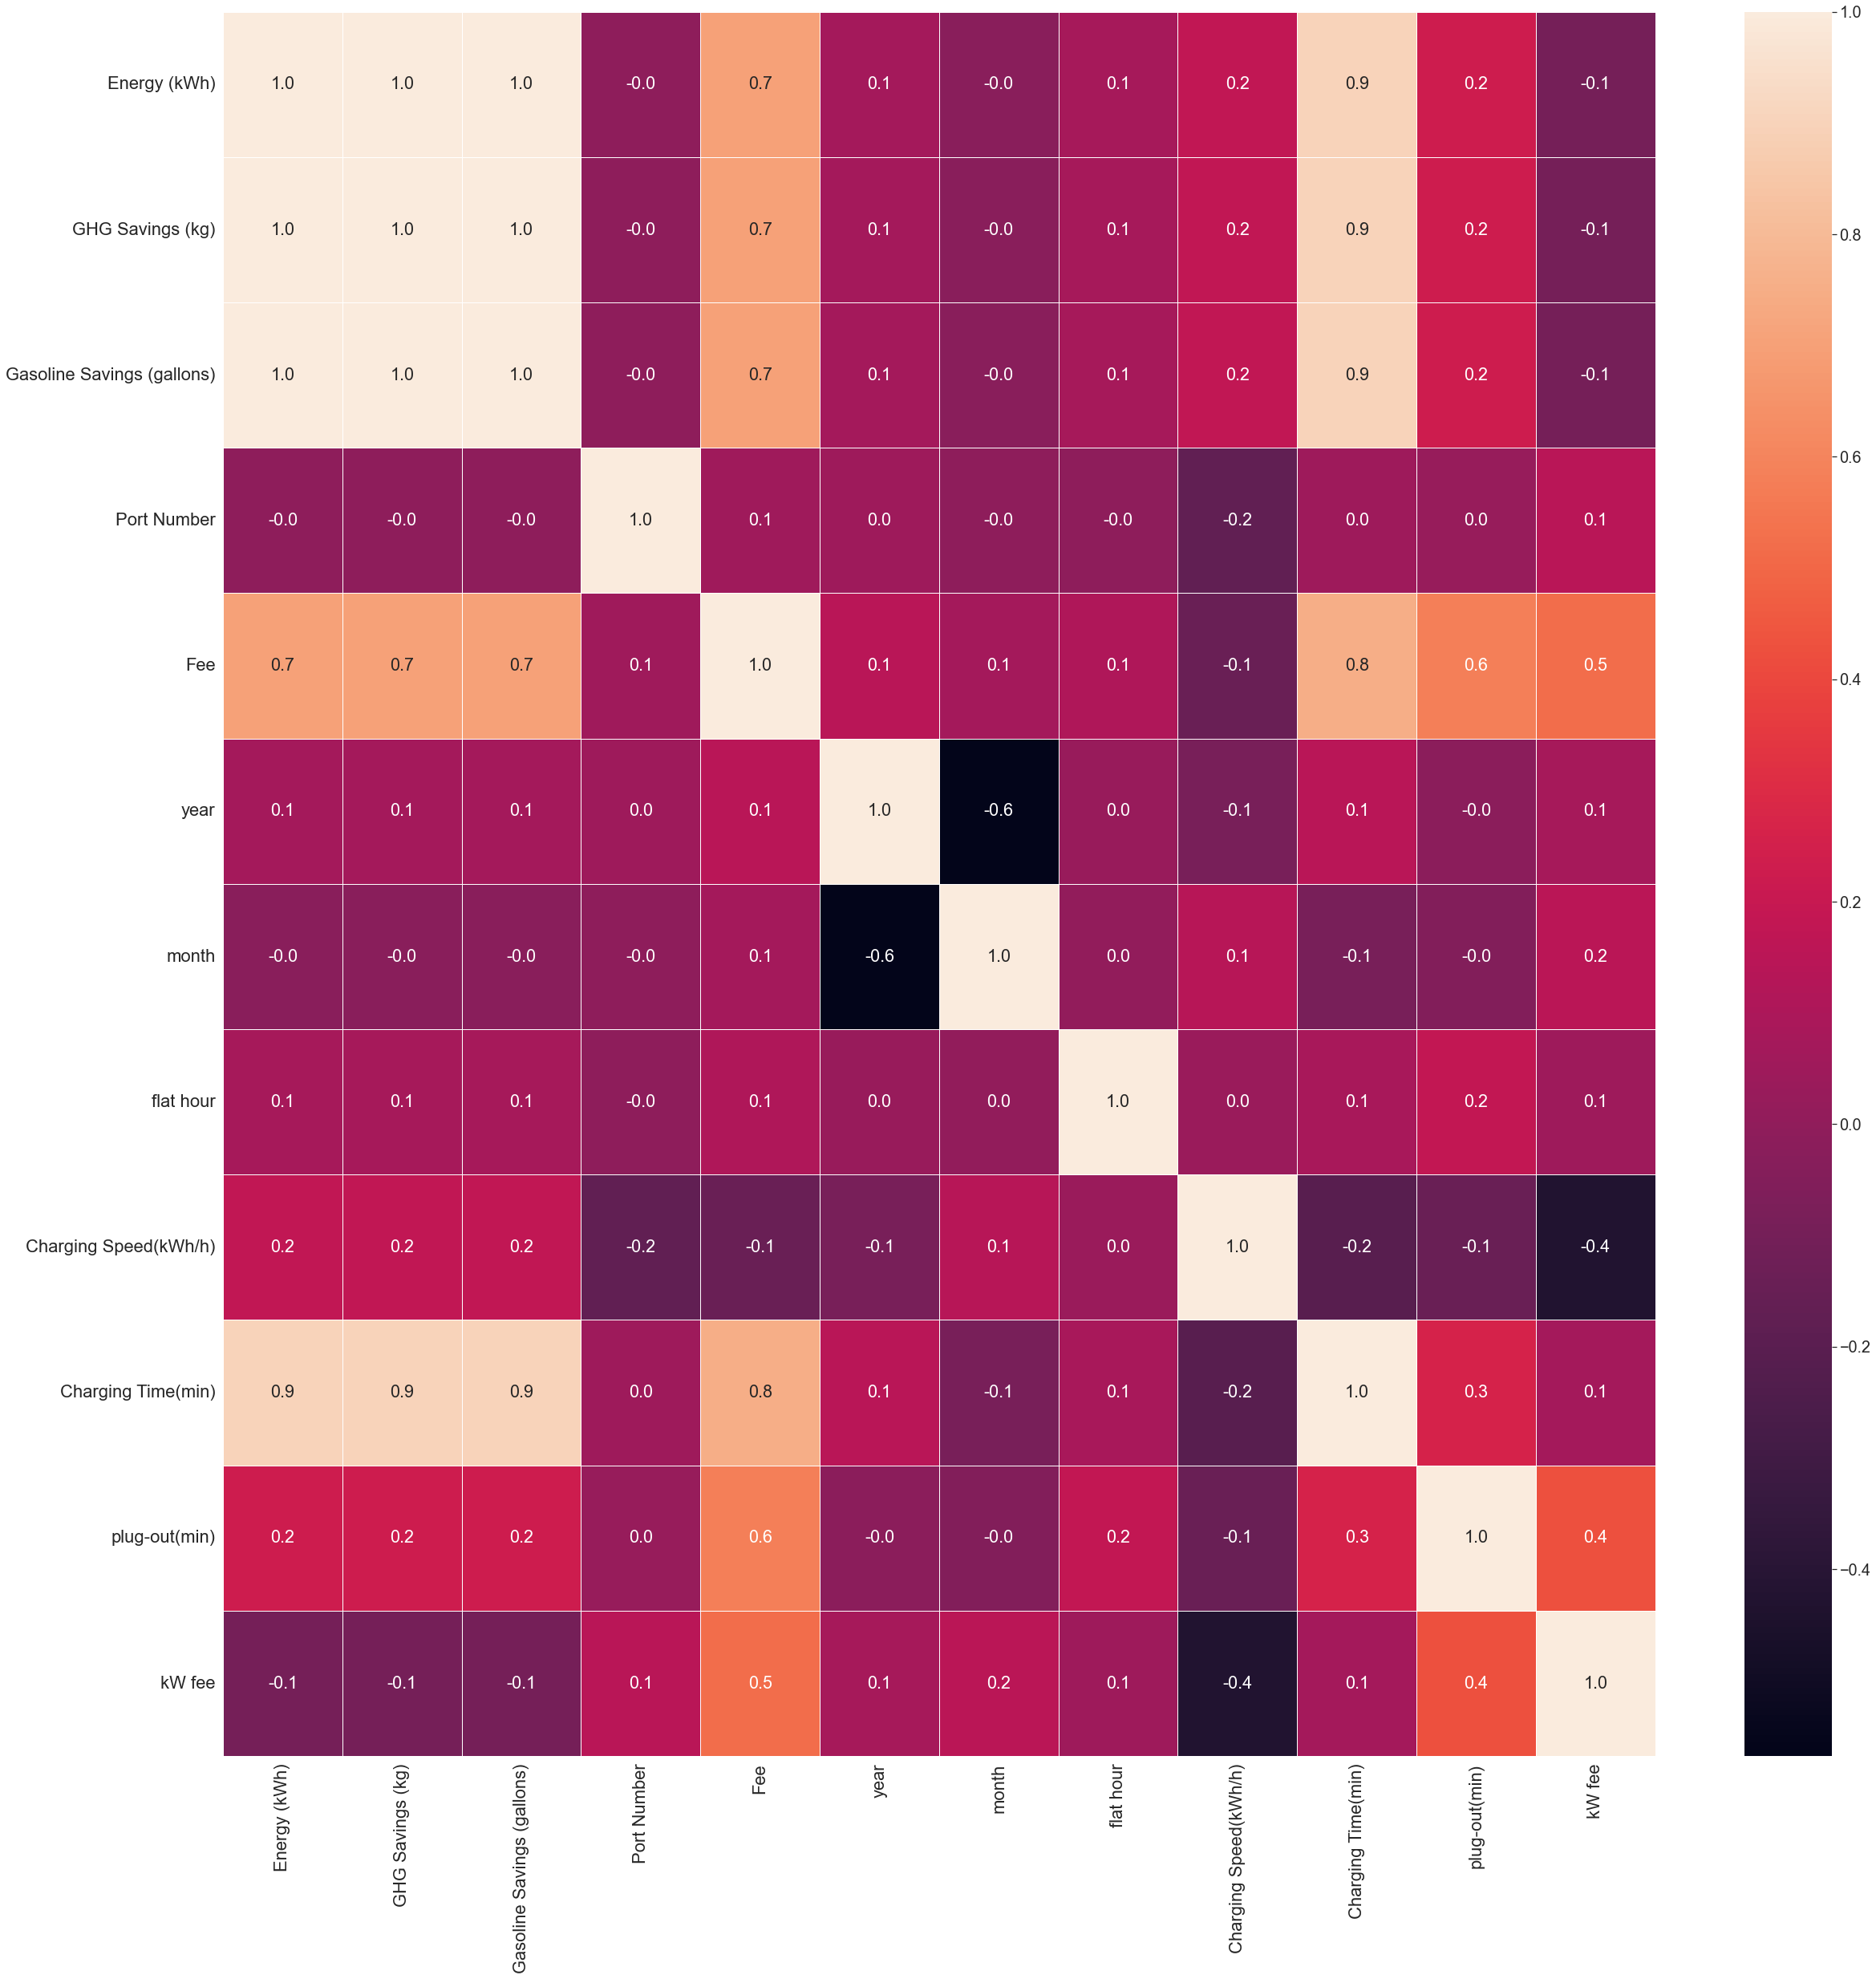

In [853]:

BIGGER_SIZE = 22
plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
f,ax = plt.subplots(figsize=(40, 40))
sns.set(font_scale=1.8)
annot_kws={"size": 20}
sns.heatmap(data.corr(), annot=True, linewidths=.8, fmt= '.1f',ax=ax)
plt.show()

lets get rid of 2015 which only have the data of 1.5 months for the sake of analysing the relation from the months of the year 2014. also get rid of the plug-in and outs. 

In [855]:
data1 = data.loc[(data['year']<2015 )]

In [856]:
data1 = data1.drop(columns=['GHG Savings (kg)','Gasoline Savings (gallons)','year','Ended By','plug-out(min)','Fee'])

In [857]:
data1 = data1.loc[(data1['Energy (kWh)']>1 )]

### Key Takeaways:


* We can see that, 1st month was free of charge and one of the most busy month. 
* Average charging time is btw 144 and 179 mins( except free month)
* Avg. charrging speed was quite stable during the year.
* Busy hours for plugging are 11:00 and 13:00
* 1st port is used as tise as the 2nd port.
* kW fees are fluctuant.
* Avg. energy consumption per session is decreased in 2nd and from 9-12th month.
* Linear relationship between kW energy consuption with other features are quite low, therefore while choosing our ML method we will also consider non- linear regression algorithms next to linear ones


In [858]:
data1.groupby(['month']).mean()

,Energy (kWh),Port Number,flat hour,Charging Speed(kWh/h),Charging Time(min),kW fee
month,,,,,,
1,10.422849,1.348837,13.848837,3.219718,195.735659,0.000000
2,9.493273,1.159091,10.931818,4.036456,144.882576,0.279224
3,10.482925,1.412500,12.012500,3.840146,166.447500,0.264257
4,10.515564,1.319149,12.063830,3.890852,166.771986,0.295776
5,10.129238,1.380952,11.428571,3.873786,160.945238,0.304191
6,10.604895,1.263158,11.789474,3.790273,164.457895,0.302202
7,10.303817,1.166667,10.800000,3.844763,166.392500,0.274828
8,10.795625,1.336538,11.548077,3.696121,179.093269,0.292234
9,9.635103,1.404412,12.507353,4.019719,153.353064,0.291537


We should just look at the Energy and Charging time columns to see the total energy consumption and busyness. October was the winner of the year. 

In [859]:
data1.groupby(['month']).sum()

,Energy (kWh),Port Number,flat hour,Charging Speed(kWh/h),Charging Time(min),kW fee
month,,,,,,
1,896.365,116,1191,276.895788,16833.266667,0.000000
2,417.704,51,481,177.604061,6374.833333,12.285875
3,838.634,113,961,307.211708,13315.800000,21.140525
4,988.463,124,1134,365.740127,15676.566667,27.802920
5,638.142,87,720,244.048525,10139.550000,19.164036
6,604.479,72,672,216.045559,9374.100000,17.225533
7,618.229,70,648,230.685755,9983.550000,16.489652
8,1122.745,139,1201,384.396587,18625.700000,30.392294
9,1310.374,191,1701,546.681806,20856.016667,39.648971


In [860]:
data2=data1.groupby(['flat hour']).sum()

In [861]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24 entries, 1 to 24
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Energy (kWh)           24 non-null     float64
 1   Port Number            24 non-null     int64  
 2   month                  24 non-null     int64  
 3   Charging Speed(kWh/h)  24 non-null     float64
 4   Charging Time(min)     24 non-null     float64
 5   kW fee                 24 non-null     float64
dtypes: float64(4), int64(2)
memory usage: 1.3 KB


Most energy loaded sesions are started around 9-10 am. 

<AxesSubplot:xlabel='flat hour'>

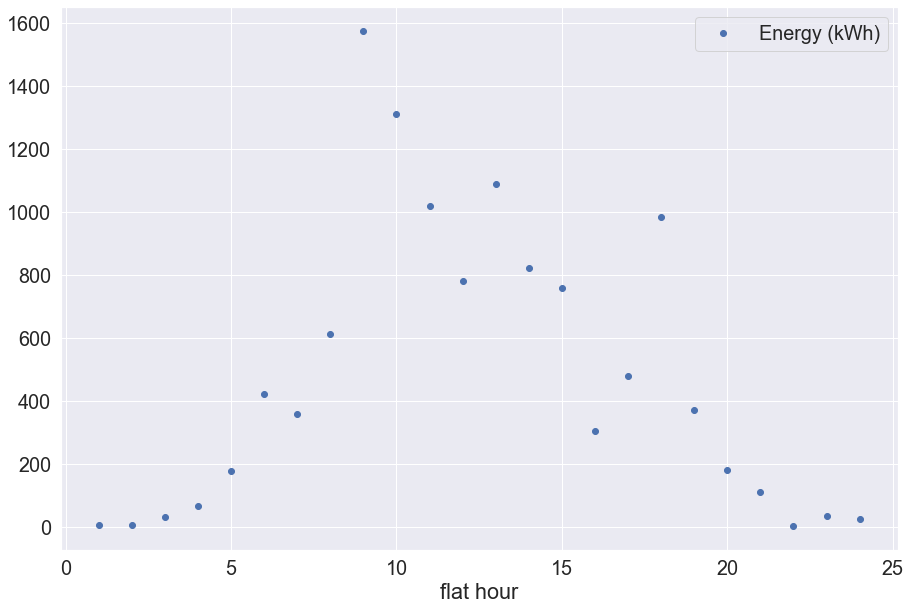

In [862]:
data2.plot(y='Energy (kWh)', style='o')

In [863]:
data3=data1.groupby(['month']).sum()

<AxesSubplot:xlabel='month'>

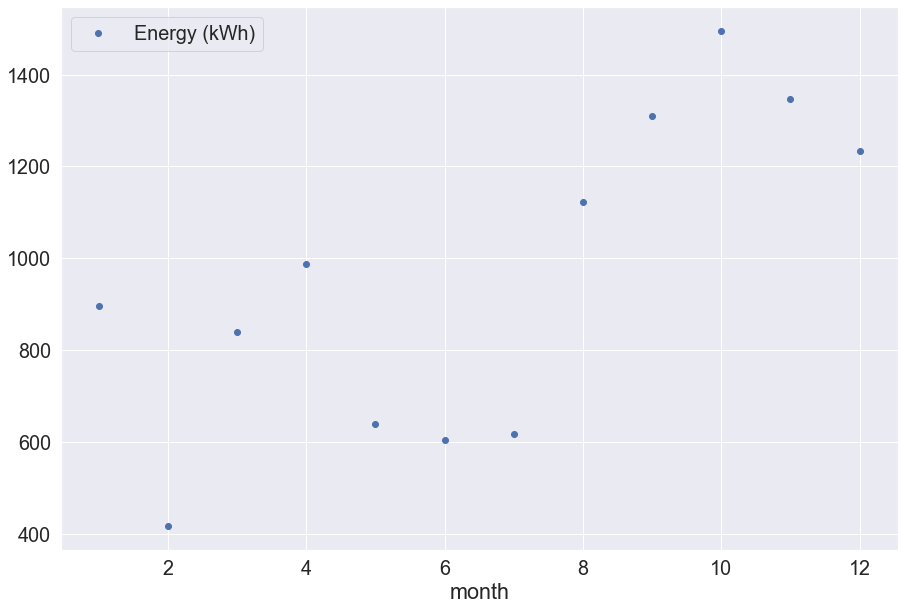

In [864]:
data3.plot(y='Energy (kWh)', style='o')

In [870]:
data1.head()

,Energy (kWh),Port Number,month,flat hour,Charging Speed(kWh/h),Charging Time(min),kW fee
257,2.186,2,12,12,1.681898,77.983333,0.960659
258,6.357,2,12,11,2.891736,131.900000,0.630801
259,1.536,1,12,11,3.200000,28.800000,0.266927
260,5.838,1,12,10,5.376516,65.150000,0.159301
261,15.720,1,12,9,3.341521,282.266667,0.254453


In [871]:
data1.describe()

,Energy (kWh),Port Number,month,flat hour,Charging Speed(kWh/h),Charging Time(min),kW fee
count,1149.000000,1149.000000,1149.000000,1149.000000,1149.000000,1149.000000,1149.000000
mean,10.018329,1.346388,7.458660,12.156658,3.823579,162.373455,0.268655
std,6.471830,0.476026,3.479568,4.021480,1.068912,89.702977,0.162257
min,1.014000,1.000000,1.000000,1.000000,0.903788,11.483333,0.000000
25%,6.163000,1.000000,4.000000,9.000000,3.024653,96.166667,0.171179
50%,9.240000,1.000000,8.000000,12.000000,3.559585,151.483333,0.248619
75%,12.471000,2.000000,10.000000,15.000000,4.536057,213.250000,0.321329
max,85.385000,2.000000,12.000000,24.000000,6.005581,865.550000,1.232514


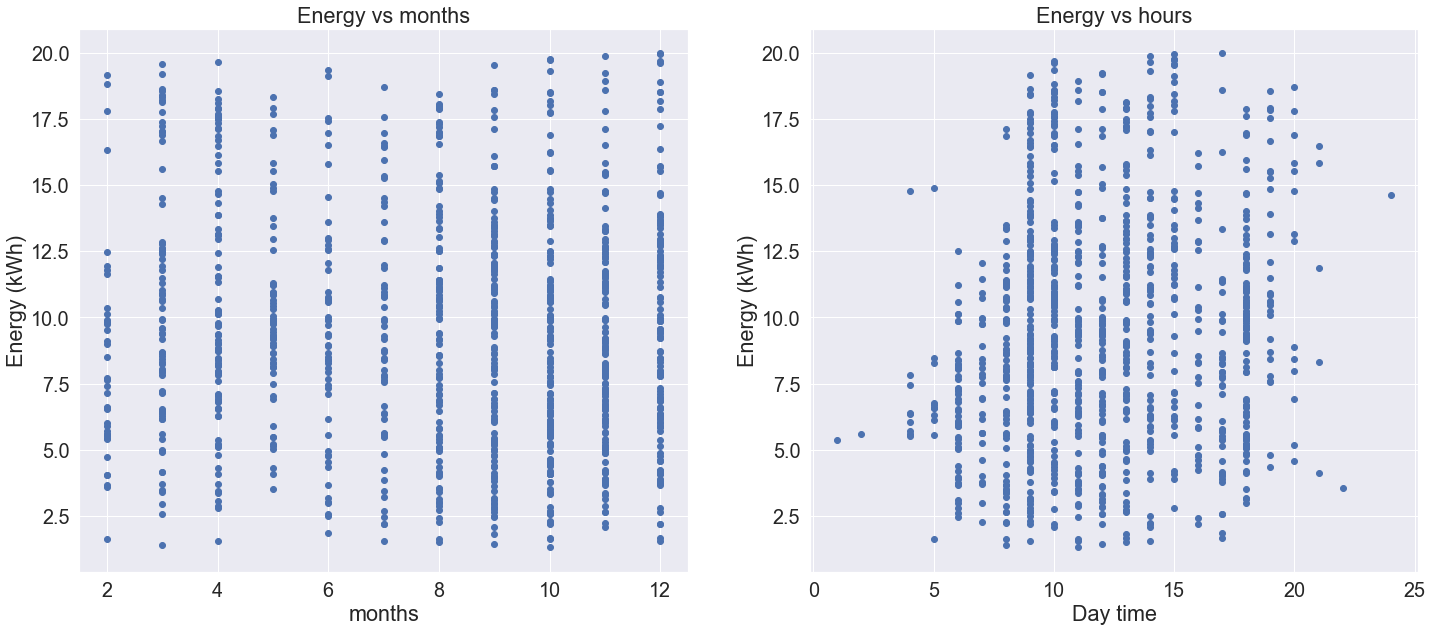

In [872]:
# Create a figure with 3 subplots in 1 row 
fig, ax = plt.subplots(1, 2, figsize=(24,10))

# Create first subplot 
ax[0].scatter(X['month'], y)
ax[0].set_title('Energy vs months')
ax[0].set_xlabel('months')
ax[0].set_ylabel('Energy (kWh)')

# Create second subplot 
ax[1].scatter(X['flat hour'], y)
ax[1].set_xlabel('Day time')
ax[1].set_title('Energy vs hours')
ax[1].set_ylabel('Energy (kWh)')

# Create second subplot 
# ax[2].scatter(X[:,2], y)
# ax[2].set_xlabel('$x_{3}$: Experimental feature #1')
# ax[2].set_title('third feature $x_{3}$ vs. label $y$')
# ax[2].set_ylabel('$y$: Median apartment value (10000€)')

# Display the figure containing two subplots 
plt.show()

# ML Model

In [1025]:
from sklearn.model_selection import train_test_split

In [874]:
data1.tail()

,Energy (kWh),Port Number,month,flat hour,Charging Speed(kWh/h),Charging Time(min),kW fee
1495,5.587,2,1,14,2.687493,124.733333,0.0
1496,21.777,1,1,14,4.531630,288.333333,0.0
1499,7.614,2,1,12,3.176176,143.833333,0.0
1504,1.327,2,1,1,2.969049,26.816667,0.0
1511,10.645,1,1,18,3.260892,195.866667,0.0


Gettin rid of the outliers

In [876]:

data1 = data1.loc[(data1['Energy (kWh)']>0 )]
# data1['Energy (kWh)'] = data1['Energy (kWh)'].dropna()

In [877]:
data1 = data1.loc[(data1['Energy (kWh)']<20 )]

In [878]:
data1 = data1.loc[(data1['kW fee']>0 )]

In [879]:
y = data1['Energy (kWh)']
X=data1.drop(columns=['Energy (kWh)','Charging Time(min)'])


In [880]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 35) #

In [881]:
X_train

,Port Number,month,flat hour,Charging Speed(kWh/h),kW fee
998,1,7,14,2.945972,0.289575
982,1,7,21,4.765522,0.178853
688,2,10,5,5.676246,0.154991
810,2,9,15,3.338244,0.282324
409,1,11,10,4.544729,0.187021
1024,1,7,9,3.432995,0.247492
677,1,10,18,3.605577,0.236557
1015,1,7,4,5.687447,0.150447
735,2,9,10,4.036292,0.210342
1196,1,4,6,3.261779,0.261194


Our features are:


* Port Number
* Month of the year
* Hour of the day
* Charging speed
* USD fee per kW energy

Our label to predict is:

* Energy (kWh) usage per session

## Linear and non-linear machine learning algorithms

There are very few linear relationship btw the features as we learned from the EDA. Therefore we also would like to consider non linear regression algorithms.

We train and fit 4 linear and 3 non-linear regression algorithms.

Below we will see the biggest number is indicating the best performing model.

Support Vector Regression

In [926]:
from sklearn import model_selection
from sklearn.svm import SVR
seed=7
kfold = model_selection.KFold(n_splits=10,shuffle=True,random_state=seed)
model13 = SVR()
scoring = 'neg_mean_squared_error'
results13 = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
print(results13.mean())

-18.990689333990293


 Decision Tree Regressor

In [927]:
from sklearn.tree import DecisionTreeRegressor

model11 = DecisionTreeRegressor()
results11 = model_selection.cross_val_score(model11,X_train, y_train, cv=kfold, scoring=scoring)
print(results11.mean())

-23.98835577190714


K Neighbors Regressor- Turns out to  be the best candidate model

In [928]:
from sklearn.neighbors import KNeighborsRegressor
model12 = KNeighborsRegressor()
results12 = model_selection.cross_val_score(model12, X_train, y_train, cv=kfold, scoring=scoring)
print(results12.mean())

-17.107063906363795


ElasticNet

In [929]:
from sklearn.linear_model import ElasticNet
model13 = ElasticNet()
results13 = model_selection.cross_val_score(model13, X_train, y_train, cv=kfold, scoring=scoring)
print(results13.mean())

-19.628401193167438


Lasso

In [930]:
from sklearn.linear_model import Lasso
model14 = Lasso()
results14 = model_selection.cross_val_score(model14, X_train, y_train, cv=kfold, scoring=scoring)
print(results14.mean())

-19.705520031982218


Ridge

In [931]:
from sklearn.linear_model import Ridge
model15 = Ridge()
results15 = model_selection.cross_val_score(model15, X_train, y_train, cv=kfold, scoring=scoring)
print(results15.mean())

-18.7186713341256


Linear Regression

In [932]:
from sklearn.linear_model import LinearRegression
model16 = LinearRegression()
results16 = model_selection.cross_val_score(model16, X_train, y_train, cv=kfold, scoring=scoring)
print(results16.mean())

-18.717080007077772


The winner model turns out KN Regressor by the biggest score -17.1

### Validation with unseen,new data

Lets Validate the models from training session to check if our hypothesis is True. Our hypothesis saying KN Regressor is the best model in prediction because it has the best training score.

Our evaluation metric will be the average of the differences between the real and predicted values(mean- error). Lower the error better the model in predicting the kW Energy consumption per session 

Linear Regression

In [933]:
model16.fit(X_train, y_train)

yhat16 = model16.predict(X_test)
yhat16=pd.DataFrame(yhat16)
yhat16['real values']=y_test
yhat16.rename( columns={0:"Predicted Energy" } ,inplace=True) 

In [934]:
yhat16['error']=abs(yhat16['Predicted Energy']-yhat16['real values'])
yhat16.head(150)

,Predicted Energy,real values,error
0,11.178630,11.390,0.211370
1,8.683189,14.015,5.331811
2,8.479379,18.499,10.019621
3,8.980345,11.231,2.250655
4,10.404178,8.683,1.721178
5,7.802107,3.689,4.113107
6,9.371166,10.510,1.138834
7,8.211600,7.991,0.220600
8,11.004711,3.906,7.098711
9,9.075320,9.233,0.157680


In [935]:
yhat16['error'].mean()

3.1440582731297

Support Vector Machine Model

In [944]:
model13.fit(X_train, y_train)

yhat13 = model13.predict(X_test)
yhat13=pd.DataFrame(yhat13)
yhat13['real values']=y_test
yhat13.rename( columns={0:"Predicted Energy" } ,inplace=True) 
yhat13['error']=abs(yhat13['Predicted Energy']-yhat13['real values'])
# yhat13.head(150)

In [937]:
yhat13['error'].mean()

3.220509129018093

 DecisionTreeRegressor

In [943]:
model11.fit(X_train, y_train)

yhat11 = model11.predict(X_test)
yhat11=pd.DataFrame(yhat11)
yhat11['real values']=y_test
yhat11.rename( columns={0:"Predicted Energy" } ,inplace=True) 
yhat11['error']=abs(yhat11['Predicted Energy']-yhat11['real values'])
# yhat11.head(150)

In [942]:
yhat11['error'].mean()

3.3522946859903406

K Neighbors Regressor

In [940]:

model12.fit(X_train, y_train)
yhat12 = model12.predict(X_test)
yhat12=pd.DataFrame(yhat12)
yhat12['real values']=y_test
yhat12.rename( columns={0:"Predicted Energy" } ,inplace=True) 
yhat12['error']=abs(yhat12['Predicted Energy']-yhat12['real values'])
yhat12.head(150)

,Predicted Energy,real values,error
0,10.0504,11.390,1.3396
1,13.7908,14.015,0.2242
2,8.5192,18.499,9.9798
3,12.8156,11.231,1.5846
4,18.0786,8.683,9.3956
5,5.1918,3.689,1.5028
6,5.1296,10.510,5.3804
7,11.1160,7.991,3.1250
8,12.7536,3.906,8.8476
9,9.1618,9.233,0.0712


In [941]:
yhat12['error'].mean()

2.935453140096617

As we can see from the mean errors, amongs all other models KN Regressor is the best predictor in unknown data with 2.9kW error rate. Our Hypothesis is TRUE.

This is proves that our training session for  different algorithms is quite credible. So we could've picked the best performing model KN Regressor and start fine tuning its hyperparameters.

#### Hyperparameter tuning of the  KN Regressor model

In [1017]:
grid_params = { 'n_neighbors' : [5,7,8,9,10,11],
               'weights' : ['uniform','distance'],
               'metric' : ['minkowski','euclidean','manhattan'],
              'leaf_size':[10,15,20,25,30],
              'p': [12,15,20,25,30]}

In [1018]:
from sklearn.model_selection import GridSearchCV
gs = GridSearchCV(KNeighborsRegressor(), grid_params, verbose = 1, cv=10, n_jobs = -1,scoring = 'neg_mean_squared_error') #scoring = 'neg_mean_squared_error'

In [1019]:
g_res = gs.fit(X_train, y_train)

Fitting 10 folds for each of 900 candidates, totalling 9000 fits


In [1020]:
g_res.best_score_

-16.26184387360626

In [1021]:
g_res.best_params_

{'leaf_size': 15,
 'metric': 'minkowski',
 'n_neighbors': 9,
 'p': 25,
 'weights': 'uniform'}

In [1022]:
knn = KNeighborsRegressor(n_neighbors = 9, leaf_size=15, p=25, weights = 'uniform',metric = 'minkowski')

In [1023]:
knn.fit(X_train, y_train)
yhat_knn = knn.predict(X_test)
yhat_knn=pd.DataFrame(yhat_knn)
yhat_knn['real values']=y_test
yhat_knn.rename( columns={0:"Predicted Energy" } ,inplace=True) 
yhat_knn['error']=abs(yhat_knn['Predicted Energy']-yhat_knn['real values'])
yhat_knn.head(150)

,Predicted Energy,real values,error
0,9.613333,11.390,1.776667
1,12.849556,14.015,1.165444
2,9.947778,18.499,8.551222
3,12.391111,11.231,1.160111
4,16.242444,8.683,7.559444
5,5.453111,3.689,1.764111
6,5.836556,10.510,4.673444
7,10.259667,7.991,2.268667
8,12.494889,3.906,8.588889
9,9.237889,9.233,0.004889


In [1047]:
yhat_knn['error'].mean()

2.83991894793344

As a result, hyperparam. tuning helped us to decrease the prediction error from 2.94 to 2.84.

In [1081]:
yhat_knn.describe()

,Predicted Energy,real values,error
count,207.000000,207.000000,207.000000
mean,9.949238,9.157671,2.839919
std,2.504463,3.973341,2.259456
min,4.577444,1.813000,0.000556
25%,8.038500,5.912500,1.162611
50%,9.882444,9.040000,2.424667
75%,11.743889,11.425500,4.196722
max,16.242444,19.359000,9.759000


Statistical comment on errors: we can see from the above table that %75 of the errors are concentrated below 2.43 kW error rate.

In [1079]:

 
plt.scatter(yhat_knn.index, yhat_knn['error'])
plt.xlabel("index")
plt.ylabel("error")
plt.show()

Graph for distrubition of the errors by 207 sessions

## Which features are the most important ones while prediction